In [1]:
import requests
import pandas as pd
from datetime import datetime
from geopy.geocoders import Nominatim

e49a90e730e178434b65ddc9689cbf9d

In [2]:
# Define las zonas representativas de cada borough
zones_names = [
    'Upper East Side, Manhattan', 'Williamsburg, Brooklyn', 'Astoria, Queens', 'Riverdale, Bronx', 'St. George, Staten Island',
    # Puedes añadir más zonas si lo deseas
]

api_key = 'e49a90e730e178434b65ddc9689cbf9d'
geolocator = Nominatim(user_agent="my_geocoder", timeout=10)
dfs = []

# Define las fechas de inicio y fin para los datos históricos
start_date = '2020-11-27'
start_date_datetime = datetime.strptime(start_date, "%Y-%m-%d")
start_date_unix = int(start_date_datetime.timestamp())

end_date = datetime.now().date().strftime("%Y-%m-%d")
end_date_datetime = datetime.strptime(end_date, "%Y-%m-%d")
end_date_unix = int(end_date_datetime.timestamp())

for zone in zones_names:
    location = geolocator.geocode(zone + ", New York, USA")
    if location:
        lat, lon = location.latitude, location.longitude

        url = f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start_date_unix}&end={end_date_unix}&appid={api_key}"
        response = requests.get(url)
        data = response.json()

        clean_data = {'date': [], 'co': [], 'pm2.5': [], 'pm10': [], 'zone': []}
        for entry in data['list']:
            clean_data['date'].append(datetime.fromtimestamp(entry['dt']).strftime('%Y-%m-%d %H:%M:%S'))
            clean_data['co'].append(entry['components']['co'])
            clean_data['pm2.5'].append(entry['components']['pm2_5'])
            clean_data['pm10'].append(entry['components']['pm10'])
            clean_data['zone'].append(zone)

        df = pd.DataFrame(clean_data)
        dfs.append(df)
    else:
        print(f"No se pudo encontrar la ubicación para {zone}")

# Combina todos los DataFrames
df_final = pd.concat(dfs, ignore_index=True)
print(df_final)

                       date       co  pm2.5   pm10                        zone
0       2020-11-27 00:00:00   547.41  14.85  22.09  Upper East Side, Manhattan
1       2020-11-27 01:00:00   520.71  14.19  20.84  Upper East Side, Manhattan
2       2020-11-27 02:00:00   514.03  14.82  21.53  Upper East Side, Manhattan
3       2020-11-27 03:00:00   534.06  16.28  23.39  Upper East Side, Manhattan
4       2020-11-27 04:00:00   554.09  17.11  24.69  Upper East Side, Manhattan
...                     ...      ...    ...    ...                         ...
135120  2024-01-08 20:00:00  1268.39  50.84  82.51   St. George, Staten Island
135121  2024-01-08 21:00:00  1295.09  55.18  88.72   St. George, Staten Island
135122  2024-01-08 22:00:00  1295.09  56.78  90.31   St. George, Staten Island
135123  2024-01-08 23:00:00  1268.39  55.63  86.37   St. George, Staten Island
135124  2024-01-09 00:00:00  1281.74  57.36  85.76   St. George, Staten Island

[135125 rows x 5 columns]


In [3]:
df_final

,date,co,pm2.5,pm10,zone
0,2020-11-27 00:00:00,547.41,14.85,22.09,"Upper East Side, Manhattan"
1,2020-11-27 01:00:00,520.71,14.19,20.84,"Upper East Side, Manhattan"
2,2020-11-27 02:00:00,514.03,14.82,21.53,"Upper East Side, Manhattan"
3,2020-11-27 03:00:00,534.06,16.28,23.39,"Upper East Side, Manhattan"
4,2020-11-27 04:00:00,554.09,17.11,24.69,"Upper East Side, Manhattan"
...,...,...,...,...,...
135120,2024-01-08 20:00:00,1268.39,50.84,82.51,"St. George, Staten Island"
135121,2024-01-08 21:00:00,1295.09,55.18,88.72,"St. George, Staten Island"
135122,2024-01-08 22:00:00,1295.09,56.78,90.31,"St. George, Staten Island"
135123,2024-01-08 23:00:00,1268.39,55.63,86.37,"St. George, Staten Island"


In [4]:
borough_mapping = {
    'Upper East Side, Manhattan': 'Manhattan',
    'Williamsburg, Brooklyn': 'Brooklyn',
    'Astoria, Queens': 'Queens',
    'Riverdale, Bronx': 'Bronx',
    'St. George, Staten Island': 'Staten Island',
    
}

df_final['borough'] = df_final['zone'].map(borough_mapping)
df_final.drop('zone', axis=1, inplace=True)

df_final


,date,co,pm2.5,pm10,borough
0,2020-11-27 00:00:00,547.41,14.85,22.09,Manhattan
1,2020-11-27 01:00:00,520.71,14.19,20.84,Manhattan
2,2020-11-27 02:00:00,514.03,14.82,21.53,Manhattan
3,2020-11-27 03:00:00,534.06,16.28,23.39,Manhattan
4,2020-11-27 04:00:00,554.09,17.11,24.69,Manhattan
...,...,...,...,...,...
135120,2024-01-08 20:00:00,1268.39,50.84,82.51,Staten Island
135121,2024-01-08 21:00:00,1295.09,55.18,88.72,Staten Island
135122,2024-01-08 22:00:00,1295.09,56.78,90.31,Staten Island
135123,2024-01-08 23:00:00,1268.39,55.63,86.37,Staten Island


In [5]:
df_final.to_csv("Co_emisions_raw_hour_borough-2020-2024.csv")

# modelo

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
def sarima_forecast(df, borough_name=None):
    # filtrar para cada distrito
    if borough_name:
        df_borough = df[df['borough'] == borough_name].copy()
    else:
        df_borough = df.copy()
    
    # Asegurar tipo de dato
    df_borough['co'] = pd.to_numeric(df_borough['co'], errors='coerce')
    df_borough['pm2.5'] = pd.to_numeric(df_borough['pm2.5'], errors='coerce')
    
    # Agrupar por mes y distrito
    df_borough = df_borough.set_index('date')[['co', 'pm2.5', 'pm10']]  # assuming 'pm10' is also numeric
    df_monthly = df_borough.resample('MS').mean()
    
    # ajustar el modelo para CO 
    sarima_model = SARIMAX(df_monthly['co'], 
                           order=(1, 1, 1), 
                           seasonal_order=(1, 1, 1, 12),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    sarima_result = sarima_model.fit(disp=False)
    
    # predecir para los siguientes 12 meses
    prediction = sarima_result.get_forecast(steps=12)
    prediction_ci = prediction.conf_int()
    
    # generar las fechas futuras predichas
    future_dates = pd.date_range(start=df_monthly.index.max(), periods=12, freq='MS')
    
    # Graficar
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=df_monthly.index, y=df_monthly['co'], label='Historical Data')
    sns.lineplot(x=future_dates, y=prediction.predicted_mean, label='Forecast')
    plt.fill_between(future_dates, prediction_ci.iloc[:, 0], prediction_ci.iloc[:, 1], color='k', alpha=0.1)
    title = 'CO Levels 12-Month Forecast' + (f' for {borough_name}' if borough_name else ' for New York')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('CO (μg/m3)')
    plt.legend()
    plt.show()

    return sarima_result

In [8]:
#Importar la base
df_emissions = pd.read_csv("Co_emisions_raw_hour_borough-2020-2024.csv")
df_emissions['date'] = pd.to_datetime(df_emissions['date'])



C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


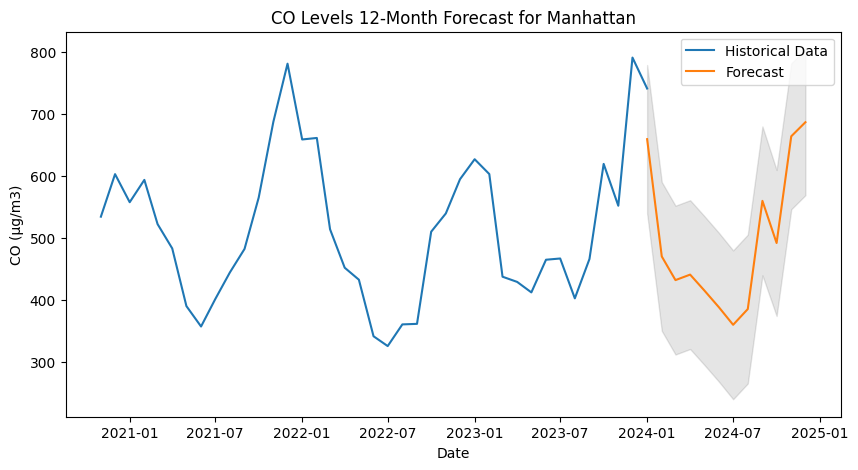

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


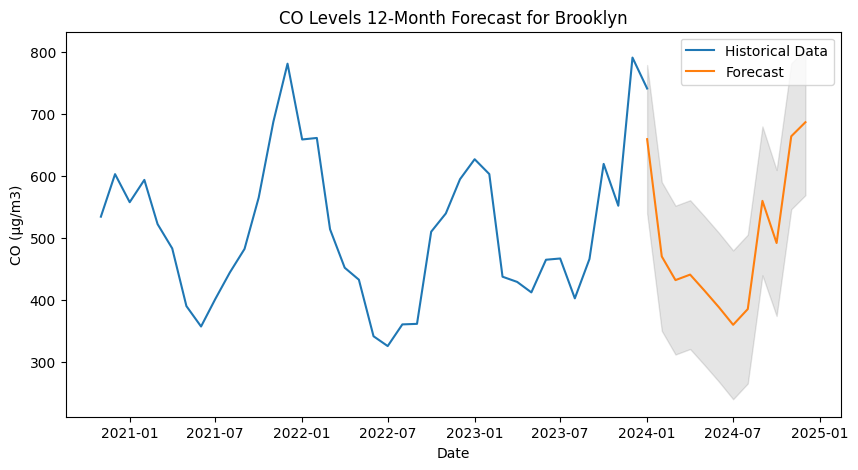

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


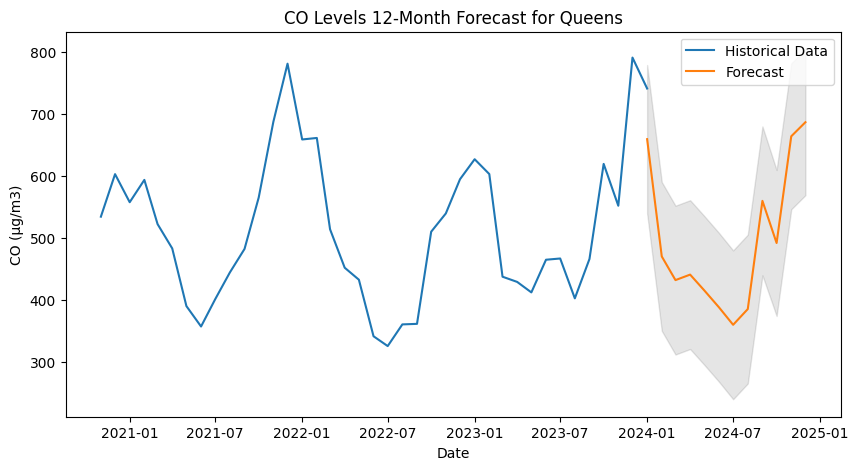

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


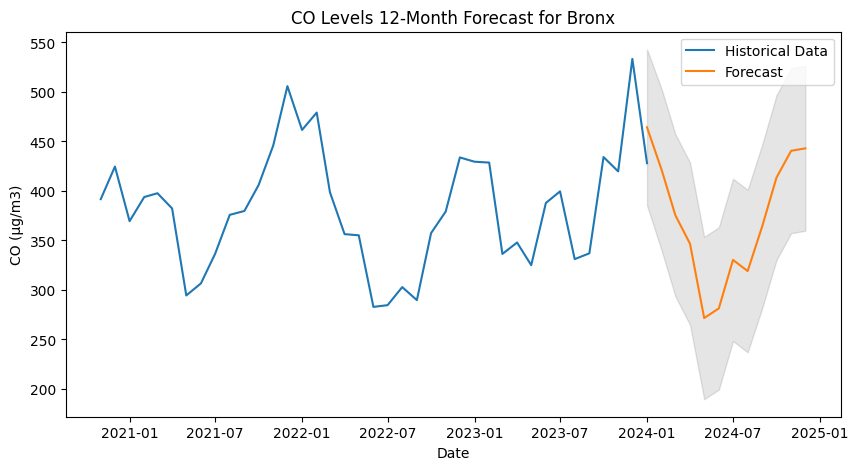

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


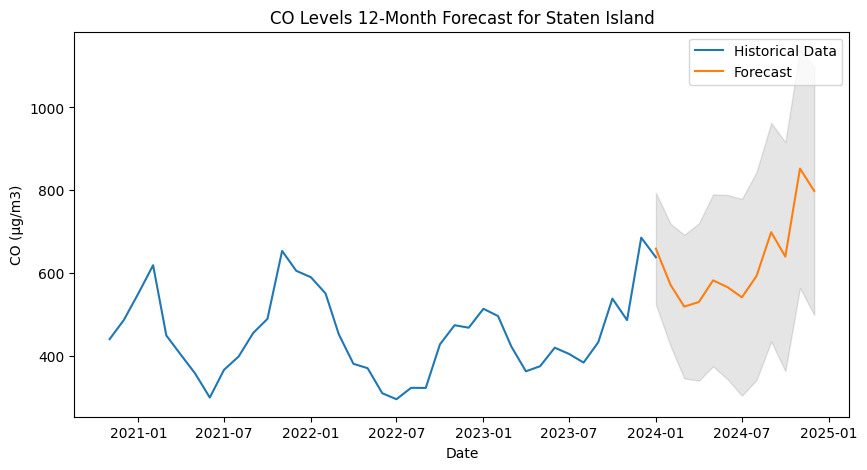

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


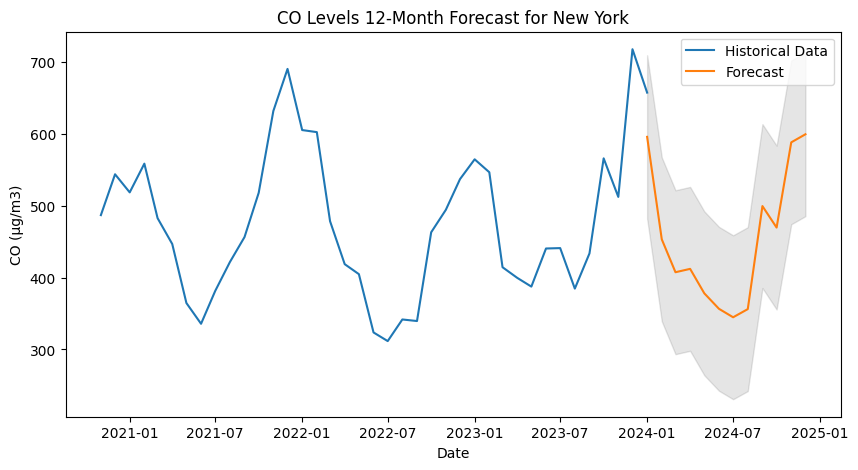

In [9]:
# Aplicar la funcion a cada borough
boroughs = df_emissions['borough'].unique()
sarima_results = {}
for borough in boroughs:
    sarima_results[borough] = sarima_forecast(df_emissions, borough_name=borough)

# Aplicar a todo new york 
sarima_results['New York'] = sarima_forecast(df_emissions)